# Logistic Regression

In this notebook I'll work through some examples using logistic regression. I'll start my making a small dataset & then building up the algorithm from scratch.

In [1]:
## imports ##
import numpy as np
import pandas as pd
import seaborn as sn 
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,precision_score,roc_curve

In [2]:
## load data ##
data = load_breast_cancer()
X    = data.data
y    = data.target

Note, regarding the labels:
* y=1 => **benign**  
* y=0 => **malignant**

In [3]:
## how many features/sample points do we have? ##
X.shape

(569, 30)

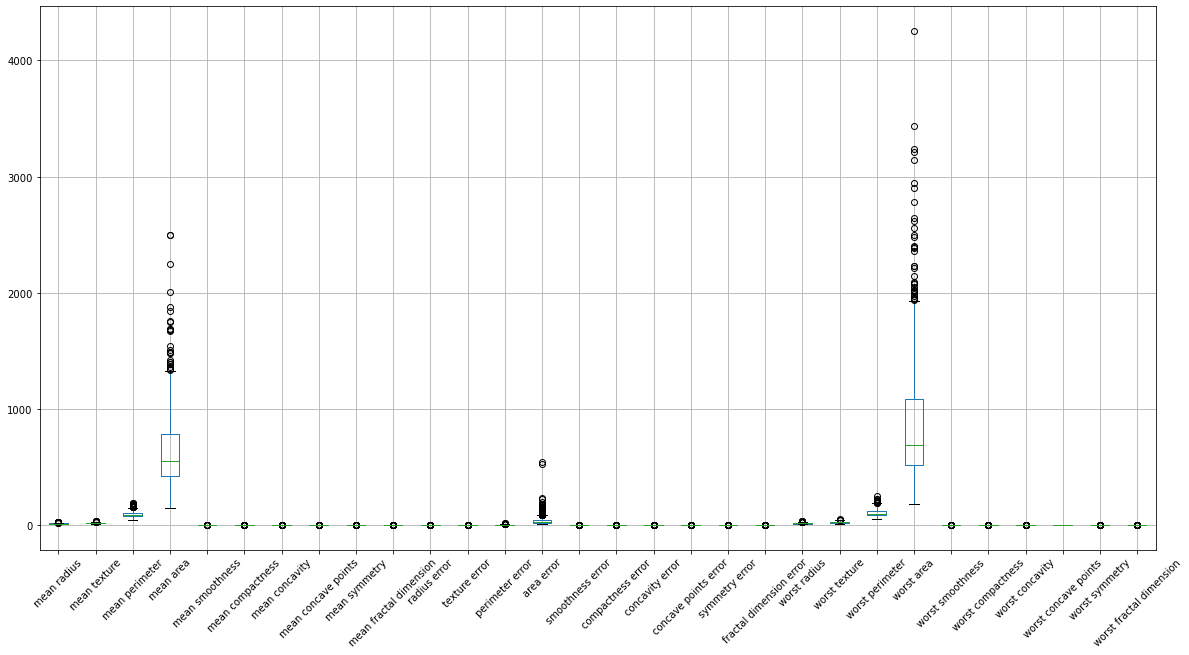

In [4]:
## make box plots of input features ##
dfX = pd.DataFrame(X,columns=data.feature_names)

dfX.boxplot(figsize=(20,10),rot=45)
plt.show()

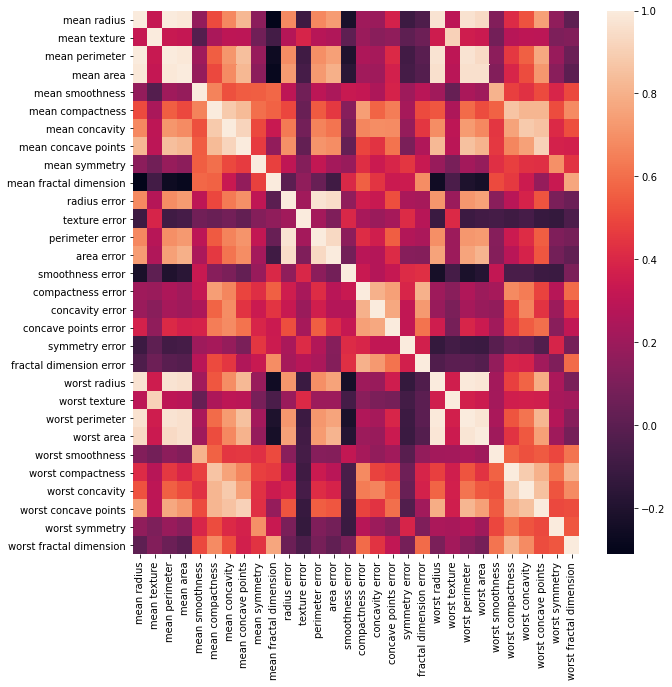

In [5]:
## plot the pearson correlation for our input features ##
fig, ax = plt.subplots(figsize = (10, 10)) 
dfCorr  = dfX.corr() 
sn.heatmap(dfCorr) 
plt.show()

In [6]:
## determine all feature pairs with corelation coef > 0.8 ##
#reformat correlation matrix
dfCorr = dfCorr.stack().reset_index()
#remove diagnonal elements
dfCorr = dfCorr[dfCorr['level_0']!=dfCorr['level_1']]
#sort and remove duplicate elements
dfCorr = dfCorr.sort_values(by=[0],ascending=False).reset_index(drop=True).iloc[::2,:]
#select values with high correlations
dfCorr = dfCorr[dfCorr[0]>0.8]

In [7]:
## view highly correlated feature pairs ##
gb = dfCorr.groupby(by=['level_0'])

for name,group in gb:
    print(name," ",group['level_1'].values)

area error   ['mean area']
compactness error   ['concavity error']
fractal dimension error   ['compactness error']
mean area   ['mean perimeter' 'mean concave points']
mean compactness   ['mean concavity']
mean concave points   ['worst perimeter' 'mean compactness' 'worst radius' 'worst area']
mean concavity   ['mean concave points' 'worst concavity']
mean perimeter   ['mean radius' 'worst radius' 'mean concave points']
mean radius   ['mean area' 'worst perimeter' 'worst area' 'mean concave points']
mean texture   ['worst texture']
perimeter error   ['radius error' 'area error']
radius error   ['area error']
worst area   ['mean area' 'mean perimeter' 'area error']
worst compactness   ['worst concavity' 'mean compactness' 'worst concave points']
worst concave points   ['mean concave points' 'mean concavity' 'mean compactness']
worst concavity   ['worst concave points' 'mean compactness']
worst fractal dimension   ['worst compactness']
worst perimeter   ['worst radius' 'worst area' 'mean

We have a listed the most highly correlated features.  Based on this we can try dropping the following 18 input features:
* mean area
* concavity error
* compactness error
* mean perimeter
* mean concave points
* mean concavity
* worst perimeter
* mean compactness
* worst radius
* worst area
* worst concavity
* mean radius
* worst texture
* radius error
* area error
* worst concave points
* worst compactness
* mean smoothness

In [8]:
## come up with a truncated feature set ##
dfXtrun = dfX.drop(['mean area',
                    'concavity error',
                    'compactness error',
                    'mean perimeter',
                    'mean concave points',
                    'mean concavity',
                    'worst perimeter',
                    'mean compactness',
                    'worst radius',
                    'worst area',
                    'worst concavity',
                    'mean radius',
                    'worst texture',
                    'radius error',
                    'area error',
                    'worst concave points',
                    'worst compactness',
                    'mean smoothness'],axis=1)

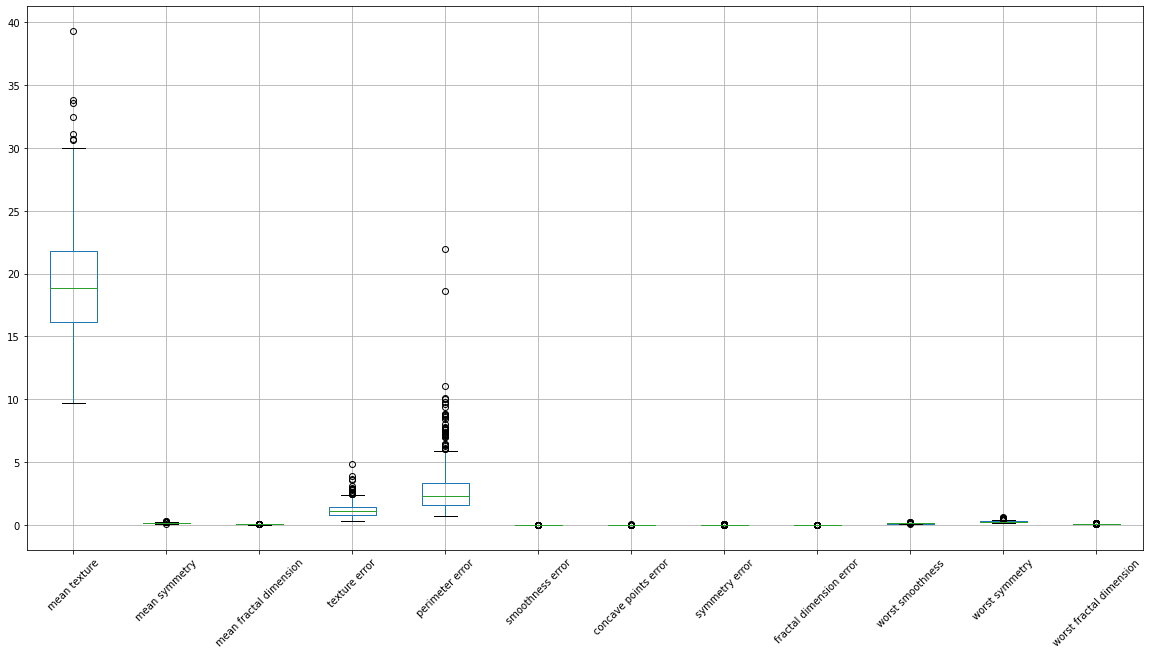

In [9]:
## box plot of truncated feature set ##
dfXtrun.boxplot(figsize=(20,10),rot=45)
plt.show()

In [10]:
## build a class to encompass the logistic regression model with the Newton-Raphson algorithm ##
class LogR:
    
    #initialiser
    def __init__(self):
        #private parameters array
        self.__B = np.array([])
    
    #train function
    def train(self,Xin,Yin,max_iter=100,tol=1e-4):
        #add column of 1's to independent variables
        X       = np.ones((Xin.shape[0],Xin.shape[1]+1))
        X[:,1:] = Xin
        #ensure correct dimensions for the input labels
        Y       = Yin.reshape(-1,1)
        #prepare parameters array
        self.__B = np.zeros((X.shape[1],1))
        #loop through the Newton-Raphson algorithm
        for i in range(max_iter):
            #compute conditional probabilities
            P = 1/(1 + np.exp(-np.matmul(X,self.__B)))
            #built diagonal matrix
            D = np.diag(np.multiply(P,(1-P)).flatten())
            #parameter update rule
            Minv      = np.linalg.inv(np.matmul(np.matmul(X.T,D),X))
            dB        = np.matmul(np.matmul(Minv,X.T),np.subtract(Y,P))
            self.__B += dB
            #check if we've reached the tolerance 
            if tol > np.linalg.norm(dB):
                break
        #return
        return
        
    #predict function
    def predict(self,Xin,return_prob=False):
        #add column of 1's to independent variables
        X       = np.ones((Xin.shape[0],Xin.shape[1]+1))
        X[:,1:] = Xin
        #calculate predictions
        Yp      = 1/(1 + np.exp(-np.matmul(X,self.__B)))
        #return predictions
        if not return_prob:
            Yp = Yp.round(decimals=0)
        return(Yp)
    
    #return model parameters
    def return_B(self):
        return(self.__B)    

Since the input features are not on the same scale, we'll scale them to mean 0 and standard deviation 1 before modelling

In [11]:
## scale input features ##
scaler = StandardScaler()
Xtrun  = scaler.fit_transform(dfXtrun)

In [12]:
## do train/test split ##
X_train, X_test, y_train, y_test = train_test_split(Xtrun, y, test_size=0.3, random_state=42)

In [21]:
## fit our logistic regression model & generate predictions ##
#declare the model
lr = LogR()
#fit the model on the training set
lr.train(X_train,y_train)
#generate predictions & associated probabilities
ypred = lr.predict(X_test) 
yprob = lr.predict(X_test,return_prob=True)

In [22]:
## evaluate model performance ##
print("accuracy: %.2f" % accuracy_score(y_test,ypred))
print("precision: %.2f" % precision_score(y_test,ypred))

accuracy: 0.96
precision: 0.97


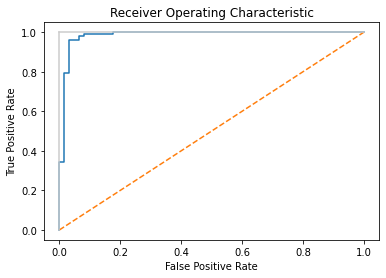

In [15]:
## create a ROC plot ##
#calculate false & true positive rates
fpr,tpr,_ = roc_curve(y_test, yprob)
#construct plot
plt.plot(fpr,tpr)
plt.title('Receiver Operating Characteristic')
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".8"), plt.plot([1, 1] , c=".8")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Instead of making a logistic regression algorithm from scratch, we can use the API provided by scikit-learn: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

In [23]:
## imports ##
from sklearn.linear_model import LogisticRegression

In [24]:
## fit our data and generate predictions ##

#declare a LinearRegression object
lr = LogisticRegression()
#fit the model
lr.fit(X_train,y_train)
#make predictions & associated probabilities
ypred = lr.predict(X_test)
yprob = lr.predict_proba(X_test)

In [25]:
## evaluate model performance ##
print("accuracy: %.2f" % accuracy_score(y_test,ypred))
print("precision: %.2f" % precision_score(y_test,ypred))

accuracy: 0.96
precision: 0.97


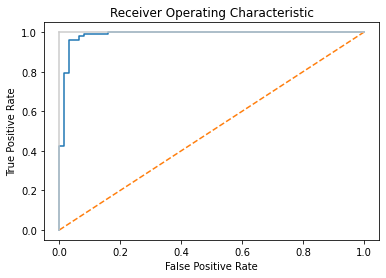

In [26]:
## create a ROC plot ##
#calculate false & true positive rates
fpr,tpr,_ = roc_curve(y_test, yprob[:,1])
#construct plot
plt.plot(fpr,tpr)
plt.title('Receiver Operating Characteristic')
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".8"), plt.plot([1, 1] , c=".8")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()